<a href="https://colab.research.google.com/github/daichi-a/AIMusicClassMaterial/blob/master/EstimatePDF_GenerateRandomFromThePDF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

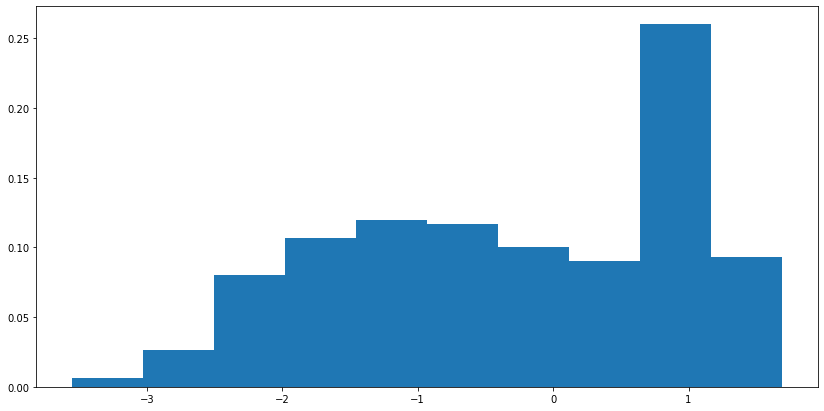

In [90]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats.distributions import norm

# 適当にデータを生成．
# ここでは平均-1，標準偏差1の正規分布から200サンプル
# 平均1，標準偏差0.3の正規分布から100サンプルを生成し，
# それを足している
np.random.seed(0)
x = np.concatenate([norm(-1, 1.).rvs(200), norm(1, 0.3).rvs(100)])

# データを正規化したヒストグラムを表示する用　度数分布が0~1の間に収まるように正規化
weights = np.ones_like(x)/float(len(x))

# ヒストグラムで確認する
plt.figure(figsize=(14,7))
plt.hist(x, weights=weights)
plt.show()

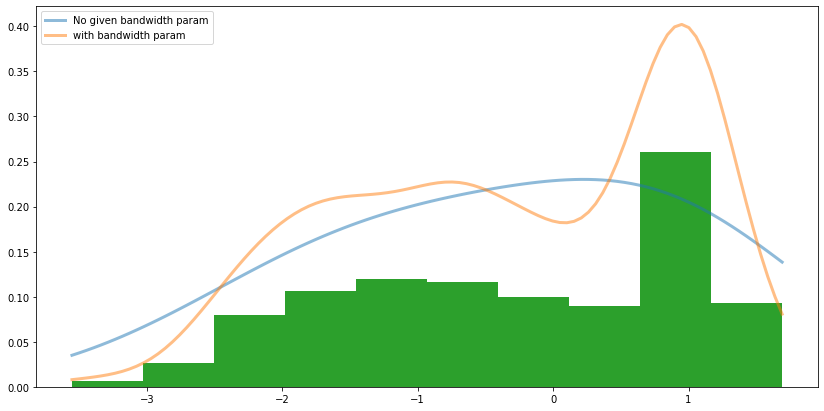

In [91]:
# この観測データの分布に沿うような分布を考える
# KernelDensity: 複数のカーネル関数の足し算として，観測データの分布を近似する方法

from sklearn.neighbors.kde import KernelDensity

# まずbandwidthを与えないデフォルトの状態
kde1 = KernelDensity(kernel='gaussian').fit(x[:, None])
# 任意の範囲を指定してスコアを得る
x_plot = np.linspace(min(x), max(x), num=100)
score1 = kde1.score_samples(x_plot[:, None])


# bandwidthを与える場合
kde2 = KernelDensity(kernel='gaussian', bandwidth=0.3).fit(x[:, None])
score2 = kde2.score_samples(x_plot[:, None])


plt.figure(figsize=(14,7))
plt.plot(x_plot, np.exp(score1), linewidth=3, alpha=0.5, label='No given bandwidth param')
plt.plot(x_plot, np.exp(score2), linewidth=3, alpha=0.5, label='with bandwidth param')
plt.hist(x, weights=weights)
plt.legend()
plt.show()

# bandwidthを与えないと，まともに推定できない

{'bandwidth': 0.2}


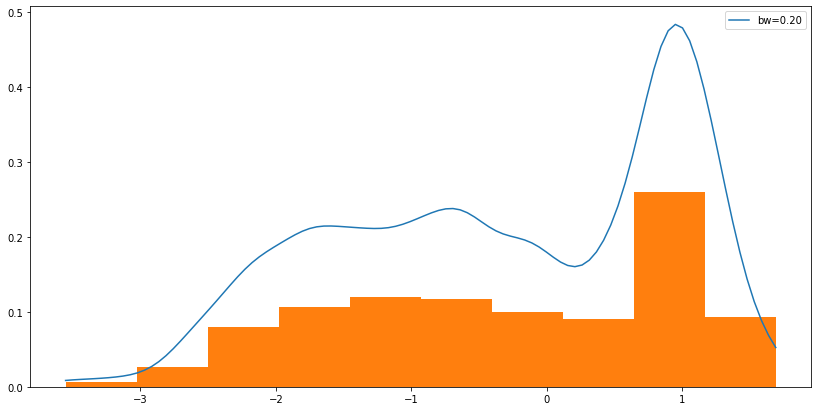

In [77]:
# bandwidthパラメータが不明なので，これをグリッドサーチする．
# 10段階ならまぁ許容範囲内だろう．
from sklearn.model_selection import GridSearchCV

grid = GridSearchCV(KernelDensity(),
                    {'bandwidth': np.linspace(0.1, 1.0, 10)}, #グリッドサーチするパラメータの範囲
                    cv=20)
# cvはcross-validation generator or an iterableって書いてあるので，
# おそらく回数だろう


grid.fit(x[:, None])
print(grid.best_params_)

# 最適解のモデルを取得する
kde_model_best = grid.best_estimator_

# x軸を表示するためのデータ
x_grid = np.linspace(min(x), max(x), num=100)
# 表示する幅に合わせたscoreを取得
best_score = kde_model_best.score_samples(x_grid[:, None])

plt.figure(figsize=(14,7))
plt.plot(x_grid,  np.exp(best_score), label='bw=%.2f' % kde_model_best.bandwidth)
plt.hist(x, weights=weights)
plt.legend()
plt.show()

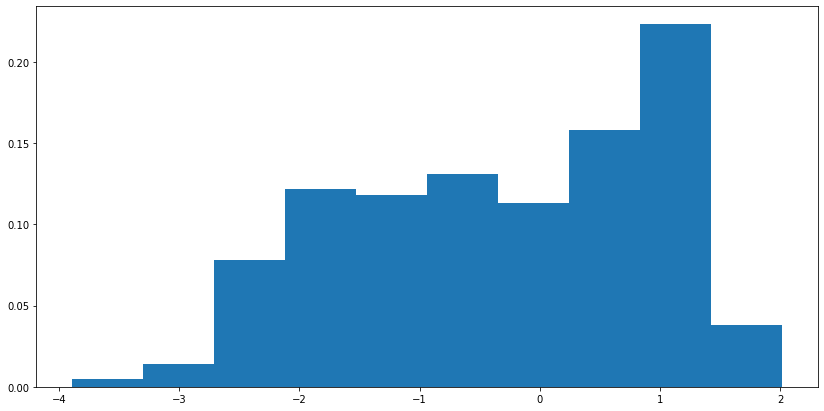

In [92]:
# 推定した複数のカーネル関数から構成された確率密度関数からサンプリングする
random_numbers = kde_model_best.sample(1000, random_state=0)
# random_stateは乱数種

# histgramを作る
this_weights = np.ones(1000) / 1000.0
plt.figure(figsize=(14,7))
plt.hist(random_numbers, weights=this_weights)
plt.show()

# KDEで推測した確率密度関数と大体同じ形状になっている，はず．

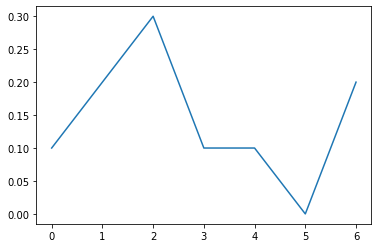

[0 2 4 3 6 1 6 2 2 2 1 1 4 0 1 0 6 3 1 4 6 6 6 0 2 1 2 2 1 2 2 6 0 2 6 3 6
 3 4 2 1 6 2 1 6 6 2 1 0 3 6 1 2 0 0 3 6 2 6 1 1 6 2 3 0 1 0 6 1 6 2 6 2 1
 0 1 2 6 2 6 2 0 2 3 1 3 2 0 4 2 0 2 1 6 1 6 2 2 6 3]
[0.14 0.2  0.27 0.1  0.05 0.   0.24]


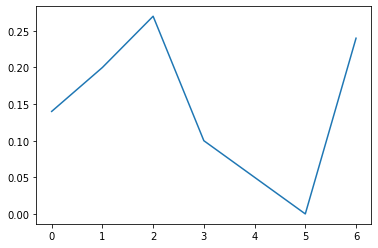

In [72]:
# 今のは連続の話だったので，離散値の話
# 離散の場合式を作らなきゃいけないわけではないので，
# こっちはめちゃくちゃシンプル

from scipy import stats
# x軸
xk = np.arange(7)
# 上記に対応する確率
pk = [0.1, 0.2, 0.3, 0.1, 0.1, 0.0, 0.2]
# 離散分布を作成
custm = stats.rv_discrete(name='custm', values=(xk, pk))

# 可視化
plt.plot(xk, custm.pmf(xk))
plt.show()

# この確率に従って1000個のデータを作る
# np.random.seed(0)
sampled_rvs = custm.rvs(size=100)
print(sampled_rvs)
# 正規化したヒストグラムを計算
f = np.histogram(sampled_rvs, bins = np.arange(7 + 1), density=True)[0]
print(f)
plt.plot(np.arange(7), f)
plt.show()

# こうやってみると，リサンプリングした形状が，元に与えた確率とはちょっと違っている．
# 当然リサンプリングの度に形は変わるが，当たり前だが極端に外れるのは出ていない．これが確率を使う意味